# Gaussian Process for Event likelihoods

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions

## Creating some random data

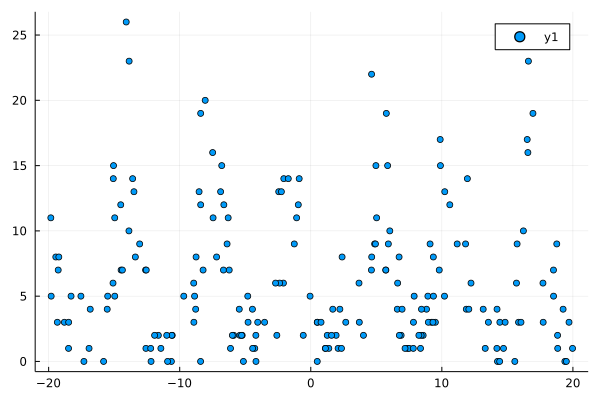

In [2]:
n_data = 200
X = (rand(n_data) .- 0.5) * 40
r = 5.0
Y = rand.(NegativeBinomial.(r, AGP.logistic.(sin.(X))))
scatter(X, Y)

## Run GP model with negative binomial likelihood to learn p

In [3]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_negbinomial = VGP(
    X, Y, kernel, NegBinomialLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_negbinomial, 20)

[ Info: Starting training Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:02
  iter:  20
  ELBO:  -551.4405311386813
[ Info: Training ended after 20 iterations. Total number of iterations 20
  3.071130 seconds (6.85 M allocations: 416.669 MiB, 2.93% gc time, 97.95% compilation time)


(Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference , (local_vars = (c = [0.4230826657416382, 0.4021245961109316, 0.43911209370453524, 0.23832779705995552, 0.3092580596805994, 0.297209703049974, 0.44555420520885397, 0.21824436364874913, 0.4501347022589812, 0.19342803313243861  …  0.3503579782172203, 0.37132248574127896, 0.22357428199295942, 0.44901246794826527, 0.3527480250378217, 0.5377695522777128, 0.267948453917915, 0.6010484166438018, 0.1955340127478129, 0.33052488502129274], θ = [6.897419735844644, 3.453586656676158, 2.4605890312343193, 3.4835268542088356, 3.4723690739519997, 6.948923194689466, 3.935114935223499, 6.47432238752344, 8.359326277014373, 6.978256280208783  …  4.454526590547039, 4.943331063597983, 3.485493415144353, 9.835309404470053, 6.433428023713664, 2.929732391554593, 3.97623846001888, 3.8837771266623697, 6.479369036250084, 4.954972389708968]), opt_state = (NamedTuple(),), hyperopt_state = (NamedTuple

## Running the same model but with a Poisson likelihood

In [4]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_poisson = VGP(
    X, Y, kernel, PoissonLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_poisson, 20)

[ Info: Starting training Variational Gaussian Process with a Poisson Likelihood (λ = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:01
  iter:  20
  ELBO:  -670.5904289358259
[ Info: Training ended after 20 iterations. Total number of iterations 20
  2.106845 seconds (4.34 M allocations: 302.629 MiB, 3.19% gc time, 92.96% compilation time)


(Variational Gaussian Process with a Poisson Likelihood (λ = 13.344029573587756) infered by Analytic Variational Inference , (local_vars = (c = [0.38531651092688124, 0.6045585911215868, 0.6399216892372981, 0.39846680032723564, 0.49945759598991973, 0.2128518370120262, 0.629175364819247, 0.13870858389607568, 0.4216364265867806, 0.2729405713842692  …  0.5447548791539512, 0.5008489806683647, 0.17274893551405252, 0.4214894592100362, 0.2879564575841878, 0.7308801408457061, 0.3580191741097569, 0.7720750672032458, 0.3290220051326923, 0.48922051574042447], θ = [7.143606015922295, 5.111750219243385, 4.181421002950285, 4.862512506825825, 5.0042551261302055, 7.581543244112136, 5.606847475111192, 7.264456685556925, 8.58420238412755, 8.124436911141268  …  6.031219825915404, 6.350618815400934, 4.322391458366087, 10.023745688518565, 6.862512609756463, 4.749933102651254, 5.20587259212176, 5.709267921478821, 7.74046971660576, 6.405880772911035], γ = [5.4635432839348255, 8.533003192230884, 8.646294896016

Prediction and plot function on a grid
Create a grid and compute prediction on it

In [5]:
function compute_grid(model, n_grid=50)
    mins = -20
    maxs = 20
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_grid (generic function with 2 methods)

Plot the data as a scatter plot

In [6]:
function plot_data(X, Y)
    return Plots.scatter(X, Y; alpha=0.33, msw=0.0, lab="", size=(800, 500))
end

function plot_model(model, X, Y, title=nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model, n_grid)
    p = plot_data(X, Y)
    Plots.plot!(
        p,
        x_grid,
        y_grid;
        ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
        title=title,
        color="red",
        lab="",
        linewidth=3.0,
    )
    return p
end;

## Comparison between the two likelihoods

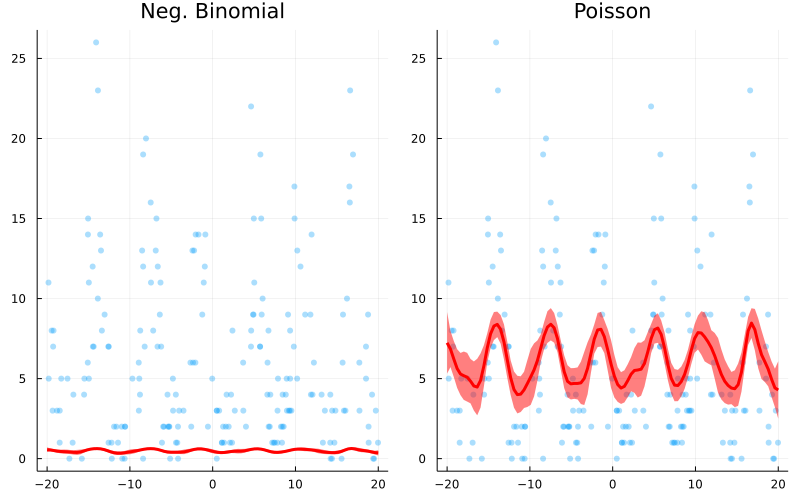

In [7]:
Plots.plot(
    plot_model.(
        [m_negbinomial, m_poisson], Ref(X), Ref(Y), ["Neg. Binomial", "Poisson"]
    )...;
    layout=(1, 2),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*